In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

import numpy as np
import pandas as pd 
import json

import matplotlib.pyplot as plt
from transformers import BertModel
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import BertTokenizer, get_linear_schedule_with_warmup

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import random
import wandb
#%pip install deepl
import deepl

import sys
sys.path.append('/home/iñaki/host_data')
import models
from CreateDataset import BertDataset, createAuxDeepLDataset

In [2]:
########################################
#                Ideas                 #
########################################

# Data Augmentation
    # Crear x10 el numero de elementos del dataset mediante LLMs
    # Una idea es utilizar como propmpt dos o tres textos aleatorios originales etiquetados igual y probar a generar un nuevo texto.
        # Se podria aletorizar tambien el propmt para variar los estilos de escritura. 
        #        (Persona de nivel cultural bajo, Entendido, Pretencioso, Misterioso, paranoico, asetivo, profesor) 
        #     Adjetivos que definen el estilo  
        # Intrincado, Descriptivo, Cautivador, Persuasivo, Elegante, Intenso, Imaginativo, Sobrio, Oscuro, Profundo, Emotivo, 
        # Surrealista, Irreverente, Oscilante, Contundente, Desgarrador, Espeluznante, Enigmático, Inquietante, Mordaz"""
        # Se podría entrenar inicialmente con estos datos, y finalmente con los originales.  
        # Finalmente testear con test, que no ha sido usado para generar prompts
        
    # Otros metodos  -  https://neptune.ai/blog/data-augmentation-nlp
        # Back translation
        # Easy methods
        #     Synonym Replacement  |  Random synonym Insertion   |   Random Swap   |    Random Deletion
        # Albumentation (libreria)
        #     Shuffle Sentences Transform 
        # Libreria para muchos de estos métodos  -  NLPAug 
        
    # Aumentado sobre embedding
        # Añadir ruido gaussiano
        # Ruido adversial
        # MixUp  (mezclar embedding y su label en la proporcion dada por una funcion)
        
    # Consistency regularization ??
    
    # Contrastive learning ??

# TRADUCIR EL DATASET ESPAÑOL A INGLES Y PROBAR

# DUDAS
    # Guardo la mejor epoch?

# TO DO tutorias
 

    # Tecnicas basicas de data aumentacion
        # Traduccion
        # MixUp
        # Ruido gaussiano
        # Ruido adversial
# ----------
     
    # Analizar matriz de confusion sobre baseline
    
    # Bert ajustado para mensajes de redes sociales (telegram)
    # investigar Equilibrado transformers
    
# Recently DONE
    # Guardar modelos para probar forma de ensembles
    # Baseline 10 folds sobre test, para tener 10 test como al probar 10 ensembles
    # Plotear distribucion de errores
    # implementar Predicciones 0, 1 o no lo se
    # Matriz de confusion
    # probar los k modelos sobre test
    # Guardar ultimo epoch de validacion, quitar MCC cada epoch, gaurdar media y desviacion del ultimo
    
    # Mirar si tiene emojis y traducirlos a texto (emojify)
    
# DONE
    #  ¿¿¿ #os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8" ???
       # ERROR  # torch.use_deterministic_algorithms(True)  
    # guardar los resultados weight and bias o ML flow
    # Intentar guardar el MCC de cada fold para poder sacar desviaciones
    # Guardar semilas.  La semilla es para que los datos sean los mismos.
    # MCC  poner etiquetas a 1 y 2  ¿¿¿ seguro ???
    # Arreglar docker
    # sacar 10% de datos del dataset como sanity-check 
    # split stratify   (sklearn viene)
    # cross validation (sklearn)

In [3]:
###############################
#       configuración         #
###############################
MODEL_NAME = "BertLargePooledOutput"

MAX_LENGTH = 512
HEAD_DROPOUT = 0
DATA_AUGMENTATION = [] #["Oversampling"]
FOLDS_NUM = 10

NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 8

FREEZE_BACKBONE = True
FREEZE_BACKBONE_EPOCHS = 7


datadir = "/home/iñaki/host_data/dataset_oppositional/"

CHECKPOINT_FOLDER = "BertlargePooledOutput"

In [4]:
# Cargamos los datasets de entrenamiento y test
train_en_dataset_path = datadir + "train_en_data.pth"
test_en_dataset_path = datadir + "test_en_data.pth"
train_es_dataset_path = datadir + "train_es_data.pth"
test_es_dataset_path = datadir + "test_es_data.pth"

# creamos los datasets de test
X, y = torch.load(test_es_dataset_path)
test_es_dataset = BertDataset(X, y)
X, y = torch.load(test_en_dataset_path)
test_en_dataset = BertDataset(X, y)

#Creamos dataloader de test
test_en_dataloader = DataLoader(test_en_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
def train_loop(model, train_dataloader, optimizer, scheduler, NUM_EPOCHS):
    train_losses = []
    for epoch in range(NUM_EPOCHS):
        # Set your model to training mode
        total_loss = 0
        total_train_samples = 0
        model.train()
        with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as tepoch:
            for i, data in enumerate(tepoch):
                input_ids, attention_mask, labels, _ = data
                # Move batch to device
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                logits = outputs.squeeze(-1)

                # Compute loss
                loss = criterion(logits, labels.float())

                # Backward pass
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Update tqdm description with loss
                tepoch.set_postfix(loss=loss.item())
                
                #update learning rate
                if scheduler:
                    scheduler.step()

            # Print average loss for this epoch
            avg_train_loss = total_loss / len(train_dataloader)
            print(f"Epoch {epoch+1}, Average Train Loss: {avg_train_loss}")
            train_losses += [avg_train_loss]
            
    return train_losses

In [6]:
def evaluate(model, test_dataloader, THRESHOLD=0.5, LOWER_UPPER_BOUND=False, val_or_test=None, plot_errors_distribution=False):
    test_outputs = []
    test_true_labels = []
    with torch.no_grad():
        total_test_loss = 0
        total_test_samples = 0
        for data in test_dataloader:
            input_ids, attention_mask, labels, _ = data
            # Save list of ground truth labels for metrics
            test_true_labels += labels.tolist()
                    
            # Move batch to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
                    
            # Forward pass
            outputs = model(input_ids, attention_mask)
            test_outputs += outputs.tolist()
            logits = outputs.squeeze(-1)

            # Compute loss
            test_loss = criterion(logits, labels.float())

            # Accumulate test loss and total number of samples
            total_test_loss += test_loss.item() * labels.size(0)
            total_test_samples += labels.size(0)
            
    # Calculate average test loss
    average_test_loss = total_test_loss / total_test_samples   
                    
    test_predictions = [1 if x[0] > THRESHOLD else 0 for x in test_outputs]
    mcc = matthews_corrcoef(test_true_labels, test_predictions)
    print(f"{val_or_test} MCC {THRESHOLD} threshold:  {mcc:.4f}")
    
    # log in wandb
    if wandb.run is not None:
        wandb.log({f"{val_or_test}_{THRESHOLD}_threshold_MCC":mcc})

    ##### matriz de confusion
    cm = confusion_matrix(test_true_labels, test_predictions)
    print(cm)

    #### get index of errors in predictions
    errors = [i for i, x in enumerate(test_predictions) if x != test_true_labels[i]]
    #### get the model outputs for the errors
    errors_outputs = [test_outputs[i] for i in errors]
    #### plot the errors with title
    if plot_errors_distribution:
        plt.hist([x[0] for x in errors_outputs]) 
        plt.title(f"{val_or_test} errors distribution")
        plt.show()

    
    # Si hay valores para el rango de valor desconocido sobre-escribimos las predicciones  
    if LOWER_UPPER_BOUND != False:
        test_predictions = [1 if x[0] > LOWER_UPPER_BOUND[1] else (0 if x[0] <= LOWER_UPPER_BOUND[0] else -1) for x in test_outputs]
        mcc = matthews_corrcoef(test_true_labels, test_predictions)
        print(f"{val_or_test} MCC with Lower_bound:{LOWER_UPPER_BOUND[0]} and upper_bound:{LOWER_UPPER_BOUND[1]} > MCC: {mcc:.4f}")
        # log in wandb
        if wandb.run is not None:
            wandb.log({f"{val_or_test}_lower_upper_{LOWER_UPPER_BOUND[0]}-{LOWER_UPPER_BOUND[1]}_MCC":mcc})
            
    # Print average test loss for this epoch
    print(f"Average {val_or_test} Loss: {average_test_loss:.4f}")
    
    return test_outputs

In [7]:
def evaluate_kfold_ensemble(predictions, test_dataloader, THRESHOLD=0.5, LOWER_UPPER_BOUND=False):
    test_true_labels = []
    with torch.no_grad():
        for data in test_dataloader:
            input_ids, attention_mask, labels, _ = data
            # Save list of ground truth labels for metrics
            test_true_labels += labels.tolist()
            
    # Mean output
    test_outputs = np.array(predictions)
    test_outputs = test_outputs.mean(axis=0)
    test_mean_predictions = [1 if x > THRESHOLD else 0 for x in test_outputs]
    mcc = matthews_corrcoef(test_true_labels, test_mean_predictions)
    print(f"test ensemble MCC {THRESHOLD} threshold: {mcc:.4f}")
    # log in wandb
    if wandb.run is not None:
        wandb.log({f"test_ensemble_{THRESHOLD}_threshold_MCC":mcc})
    # Max Voting

In [8]:
##################################
#     Weigths and bias Login    #
##################################
# MY API KEY
#    240062b42b3367d962eecb38802f856b41245735
#wandb.login(key="240062b42b3367d962eecb38802f856b41245735")


for i in range(1):
    print(f"experimento {i}:")
    #####################
    #  Reproducibilidad #
    #####################
    SEED = random.randint(0,10000)
    print(f"seed: {SEED}")
    # fuente  -  https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True


    ######################################
    #          K-FOLD TRAIN LOOP         #
    ######################################

    # CROSS VALIDATION LOOP
    X, y = torch.load(train_en_dataset_path)
    X = np.array(X)
    y = np.array(y)

    skf = StratifiedKFold(n_splits=FOLDS_NUM, shuffle=True, random_state=42)

    k_test_outputs = []
    # Loop over the folds
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"fold {fold_idx + 1}")
        
        # Weigths and bias init
        config = {
        "MAX_LENGTH": MAX_LENGTH,
        "HEAD_DROPOUT": HEAD_DROPOUT,
        "DATA_AUGMENTATION": DATA_AUGMENTATION,
        "FOLDS_NUM": FOLDS_NUM,
        "NUM_EPOCHS": NUM_EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "FOLD_IDX": fold_idx,
        "SEED": SEED
        }
        GROUP = f"{HEAD_DROPOUT}_{BATCH_SIZE}_{LEARNING_RATE}_{DATA_AUGMENTATION}"
        wandb.init(project=MODEL_NAME, group=GROUP, config=config)
        
        # Create the fold-specific train and validation sets
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        train_en_dataset = BertDataset(X_train_fold, y_train_fold)
        val_en_dataset = BertDataset(X_val_fold, y_val_fold)
        
        # Create the train dataloader with a random oversampling of the minority class
        if "Oversampling" in DATA_AUGMENTATION:
            # Oversampling Train Dataloader
            labels = [sample[2] for sample in train_en_dataset]
            class_counts = torch.bincount(torch.tensor(labels))
            class_weights = 1.0 / class_counts.float()

            weights = [class_weights[label] for label in labels]
            sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_en_dataset), replacement=True)
            train_en_dataloader = DataLoader(train_en_dataset, sampler=sampler, batch_size=BATCH_SIZE)
            print(f"Oversampling")
        else:
            print(f"No Oversampling")
            train_en_dataloader = DataLoader(train_en_dataset, batch_size=BATCH_SIZE, shuffle=True)
            
        val_en_dataloader = DataLoader(val_en_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Instanciamos el modelo cuya clase viene dada por la variable MODEL_NAME
        # Obtén la referencia a la clase del módulo models
        ModelClass = getattr(models, MODEL_NAME)
        model = ModelClass(dropout_prob=HEAD_DROPOUT)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)
        
        # Paralelizamos el modelo si hay mas de una GPU
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model, device_ids=[0, 1])
            
        # Define your loss function (binary cross-entropy in this case)
        criterion = nn.BCELoss()
          
        # Activamos todas las capas
        for param in model.parameters():
            param.requires_grad = True
        
        # Contmaos los parametros entrenables
        print(f"total params: {sum(p.numel() for p in model.parameters())} trainble params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
        

        # Define your optimizer
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
        
        # Define your learning rate scheduler
        total_steps = len(train_en_dataloader) * NUM_EPOCHS
        warmup_steps = int(total_steps * 0.1)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

        # Train the model
        train_losses = train_loop(model, train_en_dataloader, optimizer, scheduler, NUM_EPOCHS)   
        
        # Evaluate the model
        _ = evaluate(model, val_en_dataloader, THRESHOLD=0.5, val_or_test="Val")
        k_test_outputs += [evaluate(model, test_en_dataloader, THRESHOLD=0.5, val_or_test="Test")]
        
        # Save the model
        torch.save(model.state_dict(), f"/home/iñaki/host_data/checkpoints/{CHECKPOINT_FOLDER}/{MODEL_NAME}_exp-{i}_{HEAD_DROPOUT}_{DATA_AUGMENTATION}_fold_{fold_idx}.pth")
    evaluate_kfold_ensemble(k_test_outputs, test_en_dataloader)
        
    # bB - Finalizamos el experimento
    wandb.finish()

experimento 0:
seed: 7567
fold 1


wandb: Currently logged in as: inakitodc (inaki). Use `wandb login --relogin` to force relogin


No Oversampling
cuda
total params: 335142913 trainble params: 335142913


Epoch 1/5:   1%|          | 5/405 [00:24<32:01,  4.80s/batch, loss=0.812]

Test MCC 0.5 threshold:  0.6799
[[239  23]
 [ 34 104]]


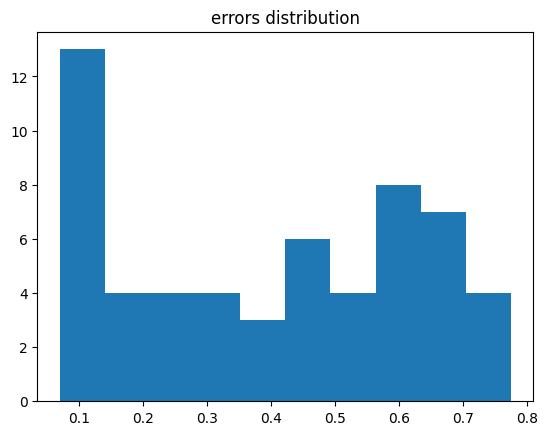

Average Test Loss: 0.3614
Test MCC 0.5 threshold:  0.6799
[[239  23]
 [ 34 104]]


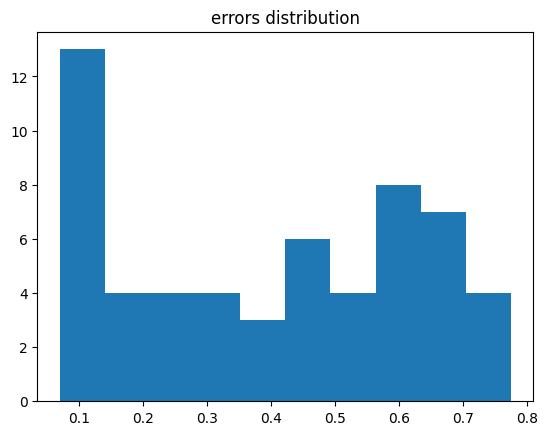

Average Test Loss: 0.3614


In [ ]:
#### Bucle cargando todos los modelos BASELINE
baseline_test_outputs = []

for model_path in os.listdir("/home/iñaki/host_data/checkpoints/Baseline/"):
    model = BertBasePooledOutput(dropout_prob=HEAD_DROPOUT)
    # Load the saved state dictionary into the initialized model
    state_dict = torch.load('/home/iñaki/host_data/checkpoints/Baseline/BertBasePooledOutput_0_[]_fold_0.pth')
    # Remove the 'module.' prefix from keys if present (esto es por ser un modelo paralelizado)
    if 'module.' in list(state_dict.keys())[0]:
        state_dict = {key[7:]: value for key, value in state_dict.items()}
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()
    baseline_test_outputs += [evaluate(model, test_en_dataloader, THRESHOLD=0.5, val_or_test="Test")]

,mcc,low,up
601,0.681704,0.49,0.51
600,0.680981,0.49,0.50
602,0.677609,0.49,0.52
576,0.677174,0.48,0.51
575,0.676431,0.48,0.50
...,...,...,...
24,0.500507,0.25,0.74
49,0.500296,0.26,0.74
99,0.497513,0.28,0.74
149,0.497492,0.30,0.74


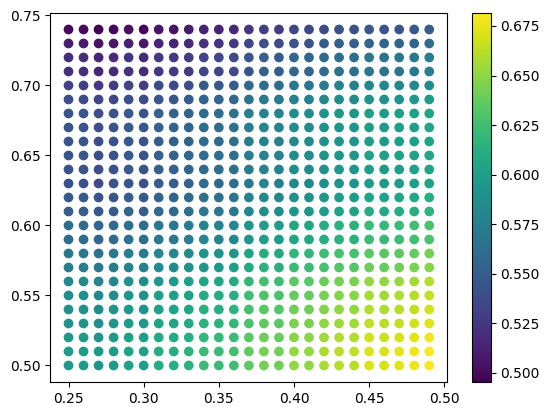

In [ ]:
# Evaluamos el valor optimo para el threshold
test_true_labels = []
for data in test_en_dataloader:
    input_ids, attention_mask, labels, _ = data
    test_true_labels += labels.tolist()

all_mcc = []
threshold = []
low, up = [], []
test_outputs = np.array(baseline_test_outputs)
test_outputs = test_outputs.mean(axis=0)
for i in range(25, 50):
    for j in range(50, 75):
        test_mean_predictions = [0 if x < i/100 else (1 if x > j/100 else -1) for x in test_outputs]
        mcc = matthews_corrcoef(test_true_labels, test_mean_predictions)
        all_mcc += [mcc]
        low += [i/100]
        up += [j/100]
        # create a df with the results and sort by mcc

df = pd.DataFrame({'mcc':all_mcc, 'low':low, 'up':up})
df = df.sort_values('mcc', ascending=False)
display(df)

# plot que representa en los ejes x e y los valores de low y up y en el eje z el mcc
plt.scatter(df['low'], df['up'], c=df['mcc'], cmap='viridis')
plt.colorbar()
plt.show()


In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>", raw=True)